**Домашнее задание**

1. скачать набор данных маркетинговых кампаний отсюда

[https://www.kaggle.com/davinwijaya/customer-retention](https://www.kaggle.com/davinwijaya/customer-retention)

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import StandardScaler

In [349]:
df = pd.read_csv('data.csv')
df['conversion'].value_counts(), df['offer'].value_counts()

(0    54606
 1     9394
 Name: conversion, dtype: int64,
 Buy One Get One    21387
 Discount           21307
 No Offer           21306
 Name: offer, dtype: int64)

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [350]:
rename_col = {'conversion': 'target', 'offer': 'treatment'}
df.rename(columns=rename_col, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [351]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [352]:
treat_map = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}
df['treatment'] = df['treatment'].map(treat_map)

In [353]:
df.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [354]:
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

learn_idxs, valid_idxs = train_test_split(X_train.index, test_size=.3, random_state=100)

In [355]:
treat_train = X_train['treatment']


X_val = X_train.loc[valid_idxs, :]
y_val = [y_train[idx] for idx in y_train.index if idx in valid_idxs]
treat_val = X_train.loc[valid_idxs, 'treatment']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

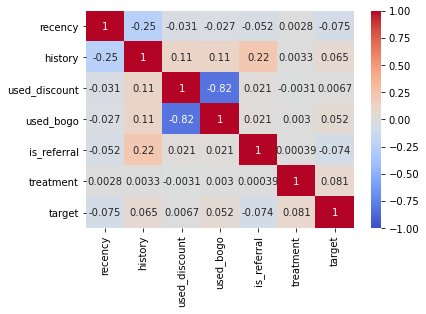

In [356]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

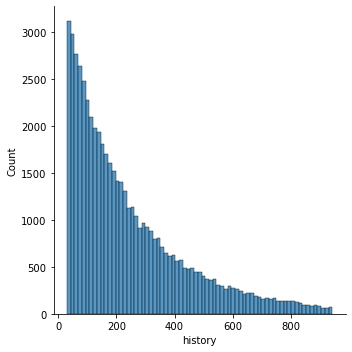

In [357]:
sns.displot((df[(df.history < df.history.quantile(.975)) & (df.history > df.history.quantile(.05))]['history']));

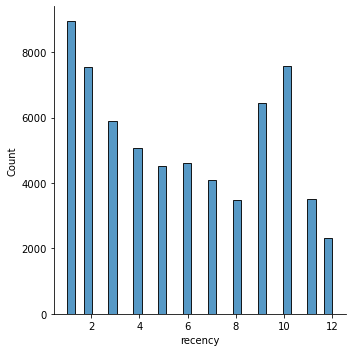

In [358]:
sns.displot(df['recency']);

In [359]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

In [360]:
df.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [361]:
base_cols = ['used_discount', 'used_bogo', 'is_referral', 'treatment']
cat_cols = ['zip_code', 'channel']
real_cols = ['recency', 'history']

In [362]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X['col_'] = 0
            return X[self.columns]
        
real_transformers = [(real_col, Pipeline([
                                ('selector', NumberSelector(key=real_col)),
                                ('standard', StandardScaler())
                                ])) for real_col in real_cols]
cat_transformers = [(cat_col, Pipeline([
                                ('selector', ColumnSelector(key=cat_col)),
                                ('le', OHEEncoder(key=cat_col))
                                ])) for cat_col in cat_cols]

base_transformers = [(base_col, Pipeline([
                                ('selector', NumberSelector(key=base_col)),
                                ])) for base_col in base_cols]

In [412]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(real_transformers+cat_transformers+base_transformers)
feature_pocessing = Pipeline([('feats', feats)])
features = ['recency','history','zip_code','channel','used_discount','used_bogo','is_referral','treatment']

# X_train = pd.DataFrame(feature_pocessing.fit_transform(X_train),
#                       columns=features)

for col in real_cols:
    scaler = StandardScaler()
    scaler.fit()
    X_train[col] = 


KeyError: "None of [Index(['recency'], dtype='object')] are in the [index]"

In [421]:
copy = X_train.copy()
s = StandardScaler()
s.fit_transform(copy[['recency', 'history']])
copy[['recency', 'history']] = s.fit_transform(copy[['recency', 'history']])

X_train = copy

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [364]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

#### Использование модели с признаком коммуникации
Using model with treatment feature

uplift@30%: -0.0085


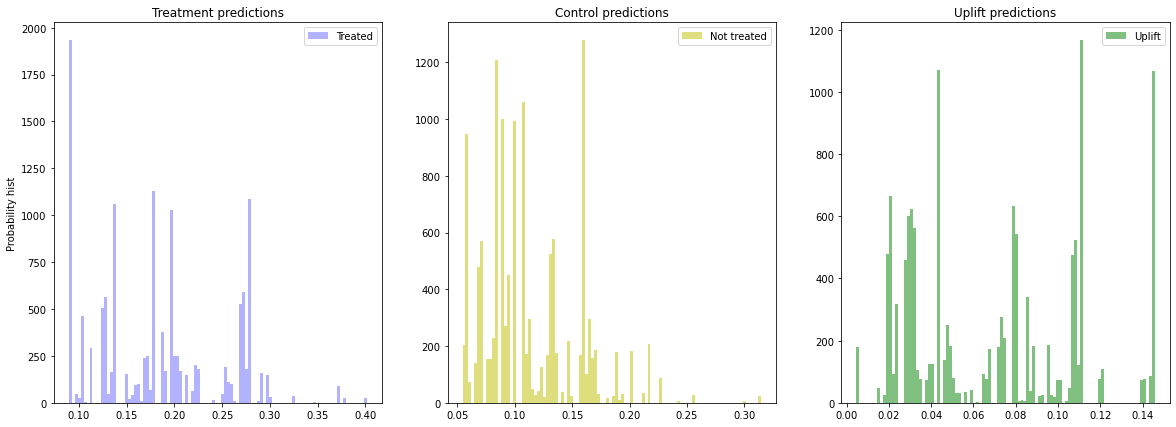

In [422]:
treat_train = X_train.treatment

cb = CatBoostClassifier(iterations=20, thread_count=2, random_seed=32, silent=True)

sm = SoloModel(cb)
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_cols})

uplift_sm = sm.predict(X_val)

sm_score10 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_sm, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=.1)
sm_score20 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_sm, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=.2)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

# with treatment
sm_trmnt_preds = sm.trmnt_preds_
# without treatment
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [423]:
sm_fi = pd.DataFrame({
            'feature_name': sm.estimator.feature_names_,
            'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)
sm_fi

,feature_name,feature_score
0,is_referral,18.376828
1,treatment,16.134952
2,recency,14.479154
3,channel,11.641250
4,zip_code,11.508141
5,used_bogo,10.762514
6,history,9.189027
7,used_discount,7.908132


#### Использование модели с трансформацией целевого признака
Using model with target transformation

In [426]:
from sklift.models import ClassTransformation
import warnings
warnings.filterwarnings('ignore')

ct = ClassTransformation(CatBoostClassifier(iterations=20, 
                                           thread_count=2,
                                           random_state=42,
                                           silent=True))
ct = ct.fit(X_train, y_train, treat_train, 
           estimator_fit_params={'cat_features': cat_cols})

uplift_ct = ct.predict(X_val)

ct_score10 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_ct, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=.1)
ct_score20 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_ct, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=.2)
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

#### Использование двух независимых моделей
Using two independent models

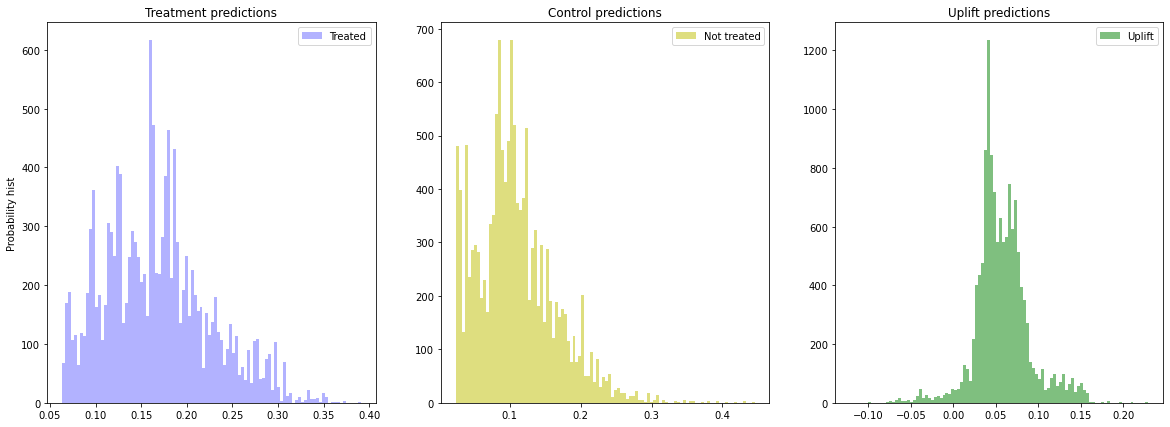

In [368]:
from sklift.models import TwoModels

tm = TwoModels(
        estimator_trmnt=CatBoostClassifier(iterations=20,
                                          thread_count=2,
                                          random_state=42,
                                          silent=True),
        estimator_ctrl=CatBoostClassifier(iterations=20,
                                          thread_count=2,
                                          random_state=42,
                                          silent=True),
        method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_cols},
    estimator_ctrl_fit_params={'cat_features': cat_cols})

uplift_tm = tm.predict(X_val)

tm_score10 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_tm, 
                       treatment=treat_val, 
                       strategy='by_group',
                       k=.1)
tm_score20 = uplift_at_k(y_true=y_val, 
                       uplift=uplift_tm, 
                       treatment=treat_val, 
                       strategy='by_group',
                       k=.2)
models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [370]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,-0.036588,-0.023772
1,ClassTransformation,-0.002376,-0.000373
2,TwoModels,-0.036964,-0.034409


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

#### Использование дерева решений
Using decision tree classifier

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8,
                                   min_samples_leaf=200,
                                   min_samples_treatment=50,
                                   n_reg=100, 
                                   evaluationFunction='KL',
                                   control_name='control')

uplift_model.fit(X_train_tree.values)

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

**Ссылки**

[https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0](https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0)

[https://habr.com/ru/company/ru_mts/blog/485980/#reference1](https://habr.com/ru/company/ru_mts/blog/485980/#reference1)

[https://en.wikipedia.org/wiki/Uplift_modelling](https://en.wikipedia.org/wiki/Uplift_modelling)

[https://www.youtube.com/watch?v=yFQAIJBYXI0](https://www.youtube.com/watch?v=yFQAIJBYXI0)

[https://www.youtube.com/watch?v=jCUcYiBK03I](https://www.youtube.com/watch?v=jCUcYiBK03I)

[https://www.uplift-modeling.com/en/latest/](https://www.uplift-modeling.com/en/latest/)

[https://arxiv.org/pdf/1809.04559.pdf](https://arxiv.org/pdf/1809.04559.pdf)

[https://catboost.ai/docs/concepts/about.html](https://catboost.ai/docs/concepts/about.html)

**Библиотеки и пакеты**

causalml

sklift

catboost